In [3]:
### running GMM without all the DJ code wrapped around it
## we read in output from collate_m and run GMM for various inputs
#  and plot distributions of some parameters
# written early/mid sept 2018, d duncan
# revisited october, 
# cleaned up and finalized plotting routines dec 2018

# Note (jan 8 2019): the rain rate calculations in this notebook are used in the
#    manuscript, but the rest is not, with the relevant difference PDF plot copied
#    over to gmm_solo.ipynb to keep plotting code in one place. This notebook was
#    more for investigation, some of which didn't make it into the paper directly. 

from sklearn import mixture
from matplotlib.colors import LogNorm, Normalize

nc = 6
run_bic = True

plt.style.use('bmh')

gmm = mixture.GaussianMixture(n_components = nc, covariance_type = 'diag')


In [4]:
typ = 'MSs3'
dir_raw_data = "/home/dudavid/projects/dsd/dj/data/"
# take every _th point to save time when debugging:
per = 1

dm = np.load('../data/alldmd'+typ+'.npy')[::per]
nw = np.log10( np.load('../data/allnwd'+typ+'.npy')[::per] ) # given as log10()
rr = np.load('../data/allrrd'+typ+'.npy')[::per]
la = np.load('../data/alllatd'+typ+'.npy')[::per]
lo = np.load('../data/alllond'+typ+'.npy')[::per]
epo= np.load('../data/allepochd'+typ+'.npy')[::per]
ss = np.load('../data/allssd'+typ+'.npy')[::per]
ku = np.load('../data/allkud'+typ+'.npy')[::per]
ka = np.load('../data/allkad'+typ+'.npy')[::per]
mu = np.load('../data/allmud'+typ+'.npy')[::per]
print(np.mean(mu),np.mean(dm),np.mean(nw))
vcts = np.load(dir_raw_data+'vallcts'+typ+'.80.npy').transpose()[::per,:] # vol-weighted, smoothed
ncts = np.load(dir_raw_data+'normallcts'+typ+'.80.npy').transpose()[::per,:] # vol-weighted and normalized
rcts = np.load(dir_raw_data+'rallcts'+typ+'.80.npy').transpose()[::per,:] # raw (per mm) counts
scts = np.load(dir_raw_data+'snallcts'+typ+'.80.npy').transpose()[::per,:] # smoothed, normalized, not weighted
rwcts =np.load(dir_raw_data+'rwallcts'+typ+'.80.npy').transpose()[::per,:] # RWC-normalized raw
cts = rwcts #ncts #vcts # choose which one to use
print(np.shape(cts))
print(np.shape(rcts))

# read in 80 size bins above, trim to __ in rest of code (most very large bins have snow, not rain)
mb = 60
bye = 1 # how many consecutive bins to sum/avg over
cts_new = np.array([ np.mean(cts[:,x*bye:(x*bye+bye)],axis=1) for x in range(int(mb/bye)) ]).transpose()
rcts_new= np.array([ np.mean(rcts[:,x*bye:(x*bye+bye)],axis=1) for x in range(int(mb/bye)) ]).transpose()
print(np.shape(cts_new))


4.494302672717009 1.17887318164054 3.697365970721966
(92116, 80)
(92116, 80)
(92116, 60)


In [5]:
bn = np.load('/home/dudavid/projects/dsd/oceanrain_binsizes.npy')[12:] # load OR bin limits
mpy = bn[0:mb:bye] # calculate midpoint below
mpy_mid = np.array([ np.mean(mpy[n:n+2]) for n in range(int(mb/bye)) ])
dD = np.array([mpy[n+1]-mpy[n] for n in range(len(mpy)-1)])

# calculate RWC from the raw data  i.e. RWC = rho*sum(4/3 pi r^3 dr)
LWC = np.array([1000.0*np.pi/6 * np.trapz( rcts_new[i,:] * (1e-3*mpy)**3, mpy ) for i in range(len(la))]) 
# should be in kg/m^3 (so multiply by a nominal depth to get an idea of rwp)
print(info(LWC)) 
print(np.shape(LWC))

['4.81E-6', '1.18E-2', '1.82E-4', '3.26E-4']
(92116,)


In [6]:
def mgd(in_D,in_Dm,in_mu,in_RWC): #Nw):
    """
     Calcuate the Modified Gamma drop size distribution

     Input (note, all inputs should be vectors of same size!) : 
            in_D:  vector of diameters [mm]
            in_Dm: mass-weighted mean diameter [mm]
            in_mu: shape parameter [dim-less]
            in_RWC: RWC [kg m-3]
            #in_Nw: normalized intercept parameter [IN LOG10()!!] [mm-1 m-3]
     output: N(D) [len(in_D)] in m^{-3} mm^{-1}
    """
    if(len(in_D)==1):
        print("need to input vector for in_D")
    enot = (4**4)/(np.pi*1000.0) * in_RWC/((in_Dm*1e-3)**4) *1e-3 
    # calc intercept param from RWC, Dm -- get units into mm-1 m-3
    #enot = 10**in_Nw
    eff = 6/(4**4) * ((4+in_mu)**(4+in_mu) ) / math.gamma(np.float128(4+in_mu))
    ModGam = enot * eff * (in_D/in_Dm)**in_mu * np.exp(-(4+in_mu)*in_D/in_Dm)
    return ModGam

In [7]:
# averaging over consecutive time steps to give a little spatial averaging sense
#   [if location varies very little for consecutive points then put them together]
#cts_new = np.array([ np.mean(cts[:,x*bye:(x*bye+bye)],axis=1) for x in range(int(mb/bye)) ]).transpose()
en = np.size(LWC)
cts_newer = cts_new
rcts_newer = rcts_new
mo = 0 # set to 3 in paper for RT simulations, but not here (set as 0 for unsmoothed)
for f in range(en-2*mo)[mo:]:
    space_var = np.std(lo[(f-mo):(f+mo+1)])+np.std(la[(f-mo):(f+mo+1)])
    time_var  = np.std(epo[(f-mo):(f+mo+1)])
    if space_var < 0.1 and time_var < 500:  # so ~10km max, mostly within 500s?
        cts_newer[f,:] = np.mean(cts_new[(f-mo):(f+mo+1),:], axis=0)
        rcts_newer[f,:] = np.mean(rcts_new[(f-mo):(f+mo+1),:], axis=0)

In [55]:
# prep MGD and GMM data to be 'normalized' by Nw and Dm then sorta rebinned:
nc1 = 6
ncx = 284
rm6 = np.load('Data_store/ND_rwcnorm_'+str(nc1)+ '.npy')
rm14= np.load('Data_store/ND_rwcnorm_'+str(ncx)+'.npy') # GMM-derived shapes, saved from gmm_solo
labels6 = np.load('Data_store/GMM-labels_rwcnorm_'+str(nc1)+'.MSs3.npy')
labels14 = np.load('Data_store/GMM-labels_rwcnorm_'+str(ncx)+'.MSs3.npy')
emgeed = np.zeros_like(rcts_new)
geeemm = np.zeros_like(rcts_new)
geeemmx= np.zeros_like(rcts_new)
for c in range(np.shape(rcts_new)[0]):
    # MGD is easy, using fuction defined
    emgeed[c,:] = mgd(mpy[:], dm[c], mu[c], LWC[c])
    
    # GMM is a bit tougher. get shape, normalize, then multiple by scale to get right LWC:
    gmm6 = rm6[labels6[c],:].flatten() # init
    rwc_avg = 1000.0*np.pi/6 * np.trapz(gmm6 * (1e-3*mpy)**3, mpy) # same for all, done above
    geeemm[c,:] = gmm6 * LWC[c]/rwc_avg
    gmmx = rm14[labels14[c],:].flatten() # init
    rwc_avg = 1000.0*np.pi/6 * np.trapz(gmmx * (1e-3*mpy)**3, mpy) # same for all, done above
    geeemmx[c,:] = gmmx * LWC[c]/rwc_avg
    
## so, i want arrays in the form of rcts_new to run through loop in following cell

In [56]:
# try to reproduce the raw data as in leinonen 2012 (fig13; by Do), bringi 2003 (fig4; by Dm)
# need to normalize x-axis by Dm and y-axis by Nw -- practically can divide counts by given Nw 
#  for each data point

justsome = np.array([abs(la) <= 90]).ravel() # all at first
thng = rcts_new[justsome,:]
savex, savey = [], []
saveymgd, saveygmm, saveygmmx = [], [], []
saveyH, saveyT = [], []
for x in range(np.shape(thng)[0]):
    dnor = mpy / dm[x] 
    nnor = thng[x,:]   / (10**nw[x])
    mnor = emgeed[x,:] / (10**nw[x])
    gnor = geeemm[x,:] / (10**nw[x])
    gnorx= geeemmx[x,:]/ (10**nw[x])
    savex.extend(dnor)
    savey.extend(nnor)
    saveymgd.extend(mnor)
    saveygmm.extend(gnor)
    saveygmmx.extend(gnorx)
print(np.shape(savex),len(savey))
savex, savey = np.array(savex), np.array(savey)
saveymgd, saveygmm = np.array(saveymgd), np.array(saveygmm)
saveygmmx = np.array(saveygmmx)
savx = savex[savey>0]
savy = savey[savey>0] # to remove zeros for log10 calc
savygmm,savymgd = saveygmm[saveygmm>0], saveymgd[saveymgd>0] # to remove zeros for log10 calc
savygmmx = saveygmmx[saveygmmx>0]
savxmgd = savex[saveymgd>0] # to remove zeros for log10 calc
savxgmm,savxgmmx = savex[saveygmm>0], savex[saveygmmx>0] # to remove zeros for log10 calc
print(np.shape(savxgmm),len(savxmgd),len(savxgmmx))




(5526960,) 5526960
(5417531,) 5526960 4097352


mu array:  [-3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.
 15.]
(150, 90) (91,)
(150,)


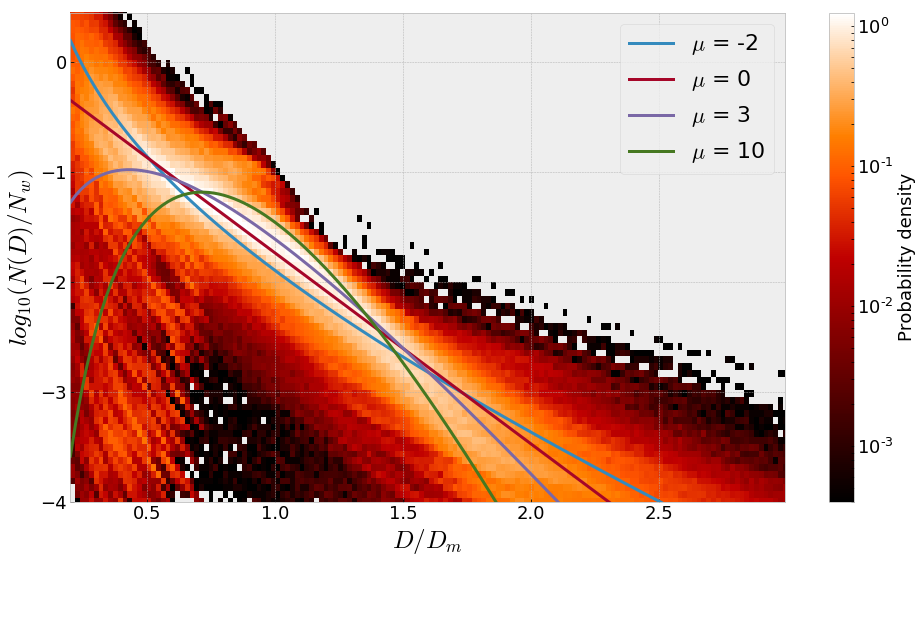

In [57]:

#print(info(np.log10(savy)),np.shape(savy))

# to insert lines for given mu values, N(D) = Nw*f(mu)*(D/Dm)**mu *exp(-(4+mu)*D/Dm), so 
#  N(D)/Nw = f(mu)*X**mu *exp(-(4+mu)*X)  where X=D/Dm
xmin, xmax = .2, 3.0
plex = np.arange(xmin,xmax,.02)
plmu = np.float128(np.arange(-3, 16)) # as in Bringi paper [need float128 or else mu>12 bombs in exponent]
gams = [math.gamma(x+4) for x in plmu]
print('mu array: ',plmu)
eff = (6/(4**4)) * (4+plmu)**(plmu+4) / gams 

fs = 22
plt.style.use('bmh') #ggplot')
f1 = plt.figure(figsize=[16,9])
cs, xx, yy, img = plt.hist2d(savxgmmx, np.log10(savygmmx), bins=[150,90], range=[[xmin,xmax], [-5,.5]], \
                             cmap=plt.get_cmap('gist_heat'),normed=1,norm=LogNorm(),vmin=4e-4,vmax=1.25)
# decided to fix max/min values to make comparable to original PDF, each other 
print(np.shape(cs),np.shape(yy))
ymid = (yy[1:] + yy[:-1]) / 2
xmid = (xx[1:] + xx[:-1]) / 2
maxd = [ ymid[cs[x,:]==np.max(cs[x,:])][0] for x in range(len(xx)-1)]
print(np.shape(maxd))


cb = plt.colorbar()
cb.set_label('Probability density',fontsize=fs-4)
plt.ylim([-4,.45])
cb.ax.tick_params(labelsize=fs-4)
plt.xlim([xmin, xmax-.01])
plt.xlabel(r'$D/D_m$',fontsize=fs+3)
plt.ylabel(r'$log_{10} (N(D)/N_w)$',fontsize=fs+3)
plt.xticks(fontsize=fs-4)
plt.yticks([-4,-3,-2,-1,0],fontsize=fs-4)

for emu in [1,3,6,13]:  # subsets are defined relative to ranged given above!
    plt.plot(plex, np.log10(eff[emu]*(plex**plmu[emu])*np.exp(-(4+plmu[emu])*plex)),\
             linewidth=3,label="""$\mu$"""+' = '+str(emu-3))
plt.legend(fontsize=fs)
pvr = 'v5'
f1.savefig('../../img/data_GMM284X-pdf_'+pvr+'.png',dpi=350,bbox_inches='tight')
#   for some reason, extra space at bottom of figure?
# MAYBE USING LIMITS DIFFERENT FROM THOSE OF THE 2DHIST ARE MESSING UP THE BBOX_INCHES CALL?
plt.show()

In [86]:

# okay, impact on precipitation flux due to velocity differences...
# reminder: velocity(D) vel = 3.78*(D**0.67) # Atlas and Ullbrich 74 (actually given in cm... 17.67D**.67)

# calculate precip flux directly for each drop size bin using N(D) and v(D)
### RR = N(D) * D**3 * v(D) * dD * pi/6 * 1e-6 * 3600  [N(D) in mm-1 m-3, D in mm, v(D) in m/s, with 
###   numberical factors coming from density (essentially kg/m2 to mm) and from mm/s to mm/hr, and pi/6
###   from 4/3 pi*r**3 into D
pflux = np.array(\
        [np.pi/6 * 3600.0 * 1e-6 * np.trapz(rcts_new[i,:]*(mpy**3)*(3.78*mpy**0.67), mpy) for i in range(len(la))]) 
pflux_mgd = np.array(\
        [np.pi/6 * 3600.0 * 1e-6 * np.trapz(emgeed[i,:]*(mpy**3)*(3.78*mpy**0.67), mpy) for i in range(len(la))]) 
pflux_gmm = np.array(\
        [np.pi/6 * 3600.0 * 1e-6 * np.trapz(geeemm[i,:]*(mpy**3)*(3.78*mpy**0.67), mpy) for i in range(len(la))]) 
#print(shinfo(pflux))
#print(info(pflux),info(rr))


['-3.38E+1', '1.40E+0', '-8.10E-2', '4.33E-1']
['-7.57E+1', '1.24E+1', '8.42E-17', '7.90E-1']


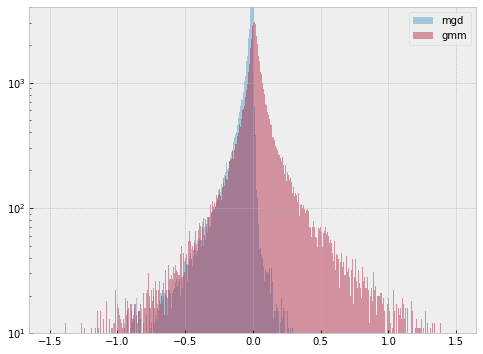

In [109]:

#print(info(pflux - rr))
#print(info(pflux_mgd - rr))
print(info(pflux_mgd - pflux)) # if negative, MGD signifies a RR underestimation
print(info(pflux_gmm - pflux))
xm = 1.5
bns = np.arange(-xm,xm,.005)
plt.figure(figsize=[8,6])
plt.hist((pflux_mgd-pflux), range=[-xm,xm],bins=bns, log=True, label='mgd', alpha=.4)
plt.hist((pflux_gmm-pflux), range=[-xm,xm],bins=bns, log=True, label='gmm', alpha=.4)
plt.legend()
plt.ylim([1e1,4e3])
#plt.yscale('log')
plt.show()


In [148]:
# copy/pasted from gmm_solo code:

justsome = np.array([abs(la) > 50]).ravel() # high lat (h)
print('mean RR dif% high:',np.mean(pflux_mgd[justsome]-pflux[justsome])/np.mean(rr[justsome]))
print('mean RR dif high:',np.mean(pflux_mgd[justsome]-pflux[justsome]))
thng = rcts_new[justsome,:]
print(np.shape(thng))
savexh, saveyh = [], []
for x in range(np.shape(thng)[0]):
    dnor = mpy / dm[justsome][x] 
    nnor = thng[x,:] / (10**nw[justsome][x])
    savexh.extend(dnor)
    saveyh.extend(nnor)
print(np.shape(savexh),len(saveyh))
savexh, saveyh = np.array(savexh), np.array(saveyh)
savxh = savexh[saveyh>0]
savyh = saveyh[saveyh>0] # to remove zeros for log10 calc

justsome = np.array([abs(la) <= 20]).ravel() # tropics (t)
print('mean RR dif% trop:',np.mean(pflux_mgd[justsome]-pflux[justsome])/np.mean(rr[justsome]))
print('mean RR dif trop:',np.mean(pflux_mgd[justsome]-pflux[justsome]))
print('mean RR dif% all:',np.mean(pflux_mgd-pflux)/np.mean(rr))
print('mean RR dif all:',np.mean(pflux_mgd-pflux))
thng = rcts_new[justsome,:]
print(np.shape(thng))
savext, saveyt = [], []
for x in range(np.shape(thng)[0]):
    dnor = mpy / dm[justsome][x] 
    nnor = thng[x,:] / (10**nw[justsome][x])
    savext.extend(dnor)
    saveyt.extend(nnor)
print(np.shape(savext),len(saveyt))
savext, saveyt = np.array(savext), np.array(saveyt)
savxt = savext[saveyt>0]
savyt = saveyt[saveyt>0] # to remove zeros for log10 calc

mean RR dif% high: -0.04078682866724936
mean RR dif high: -0.06965536579705382
(36088, 60)
(2165280,) 2165280
mean RR dif% trop: -0.02008606059355997
mean RR dif trop: -0.10316104210664082
mean RR dif% all: -0.025167478134591043
mean RR dif all: -0.08103114051685324
(20521, 60)
(1231260,) 1231260


(150, 90) (91,)
(150,)


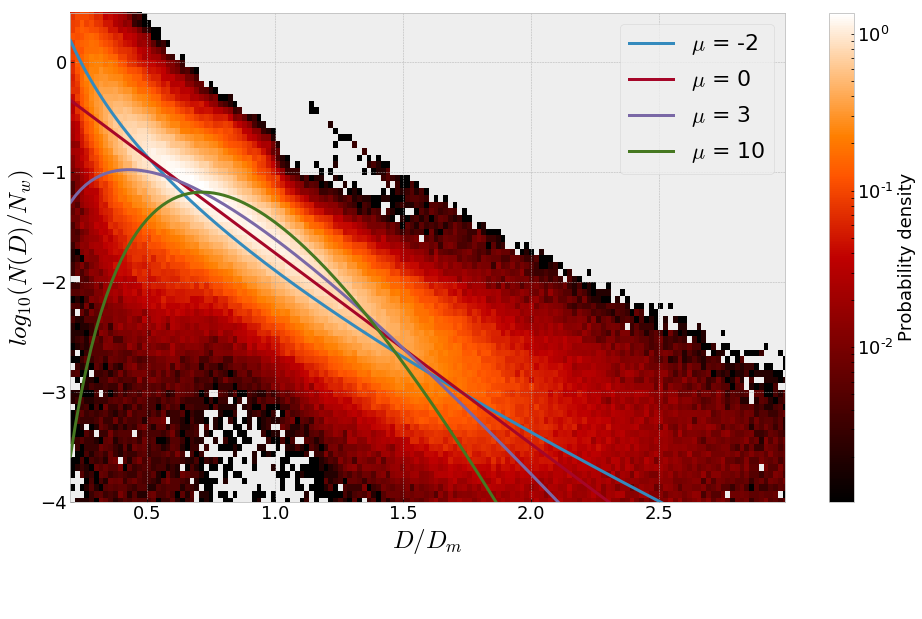

In [92]:
xmin, xmax = .2, 3.0
plex = np.arange(xmin,xmax,.02)
plmu = np.float128(np.arange(-3, 16)) # as in Bringi paper [need float128 or else mu>12 bombs in exponent]
gams = [math.gamma(x+4) for x in plmu]
eff = (6/(4**4)) * (4+plmu)**(plmu+4) / gams 

fs = 22
plt.style.use('bmh')
f1 = plt.figure(figsize=[16,9])
cs, xx, yy, img = plt.hist2d(savxh, np.log10(savyh), bins=[150,90], range=[[xmin,xmax], [-5,.5]], cmap=plt.get_cmap('gist_heat'),\
           normed=1,norm=LogNorm())
print(np.shape(cs),np.shape(yy))
ymid = (yy[1:] + yy[:-1]) / 2
xmid = (xx[1:] + xx[:-1]) / 2
maxd = [ ymid[cs[x,:]==np.max(cs[x,:])][0] for x in range(len(xx)-1)]
print(np.shape(maxd))


cb = plt.colorbar()
cb.set_label('Probability density',fontsize=fs-4)
plt.ylim([-4,.45])
cb.ax.tick_params(labelsize=fs-4)
plt.xlim([xmin, xmax-.01])
plt.xlabel(r'$D/D_m$',fontsize=fs+3)
plt.ylabel(r'$log_{10} (N(D)/N_w)$',fontsize=fs+3)
plt.xticks(fontsize=fs-4)
plt.yticks([-4,-3,-2,-1,0],fontsize=fs-4)

for emu in [1,3,6,13]:  # subsets are defined relative to ranged given above!
    plt.plot(plex, np.log10(eff[emu]*(plex**plmu[emu])*np.exp(-(4+plmu[emu])*plex)),\
             linewidth=3,label="""$\mu$"""+' = '+str(emu-3))
plt.legend(fontsize=fs)
pvr = 'v5H'
#f1.savefig('../../img/data_gammas_exp-pdf_'+pvr+'.png',dpi=350,bbox_inches='tight')
plt.show()

In [143]:
his2d    = np.histogram2d(savx, np.log10(savy), bins=(xx, yy), range=[[xmin,xmax], [-5,.5]], normed=1)
his2d_hl = np.histogram2d(savxh, np.log10(savyh), bins=(xx, yy), range=[[xmin,xmax], [-5,.5]], normed=1)
his2d_trop=np.histogram2d(savxt, np.log10(savyt), bins=(xx, yy), range=[[xmin,xmax], [-5,.5]], normed=1)
his2d_mgd =np.histogram2d(savxmgd, np.log10(savymgd), bins=(xx, yy), range=[[xmin,xmax], [-5,.5]], normed=1)


#gu = np.logical_and(his2d_mgd[0] > 0.000, his2d_hl[0] > 0.000) # choose points where both hists defined
#dif_hi = np.zeros_like(his2d_hl[0])+np.nan
dif_hi = his2d_hl[0]-his2d_mgd[0]
#dif_hi[gu] = 100*(his2d_hl[0][gu]-his2d_mgd[0][gu])/his2d_hl[0][gu] #/his2d_lp5[gu

#gu = np.logical_and(his2d_mgd[0] > 0.000, his2d_trop[0] > 0.000) # choose points where both hists defined
#dif_tr = np.zeros_like(his2d_trop[0])+np.nan
#dif_tr[gu] = 100*(his2d_trop[0][gu]-his2d_mgd[0][gu])/his2d_trop[0][gu] #/his2d_lp5[gu
dif_tr = his2d_trop[0]-his2d_mgd[0]

dif_all = his2d[0]-his2d_mgd[0]
nej = np.logical_and(his2d[0] <= 0, his2d_mgd[0] <= 0)
dif_all[nej] += np.nan

toplot = np.zeros_like(his2d_trop[0])+np.nan
gu = np.logical_and(his2d_trop[0] > 0.000, his2d_hl[0] > 0.000) # choose points where both hists defined
toplot[gu] = 100*(his2d_hl[0][gu]-his2d_trop[0][gu])/his2d_trop[0][gu] 

['-4.93E+0', '1.22E+0', '3.27E-18', '2.70E-1']


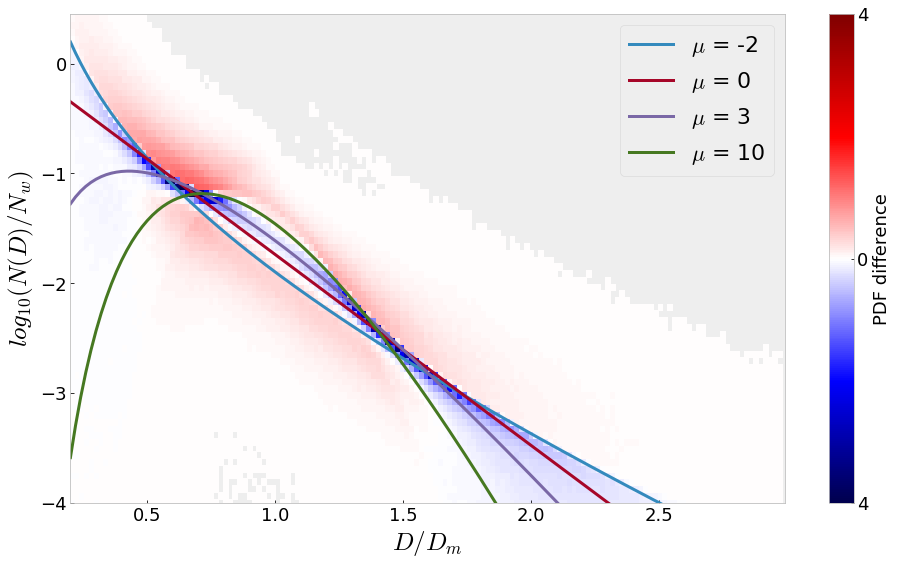

In [144]:
hd = plt.figure(figsize=[16,9])
vm = 4 #.8 #100
print(info(dif_all))
plt.pcolor(xx[:-1], yy[:-1], dif_all.transpose(), cmap=plt.get_cmap('seismic') , vmin=-vm, vmax=vm)
cb2 = plt.colorbar(ticks=[-vm,0,vm])
cb2.set_label('PDF difference',fontsize=fs-4)
cb2.ax.tick_params(labelsize=fs-4)
cb2.ax.set_yticklabels([str(round(vm,1)),'0',str(round(vm,1))])
plt.ylim([-4,.45])
plt.xlim([xmin,xmax-.01])
plt.xlabel(r'$D/D_m$',fontsize=fs+3)
plt.ylabel(r'$log_{10} (N(D)/N_w)$',fontsize=fs+3)
plt.xticks(fontsize=fs-4)
plt.yticks([-4,-3,-2,-1,0],fontsize=fs-4)
for emu in [1,3,6,13]:  # subsets are defined relative to ranged given above!
    plt.plot(plex, np.log10(eff[emu]*(plex**plmu[emu])*np.exp(-(4+plmu[emu])*plex)),\
             linewidth=3,label="""$\mu$"""+' = '+str(emu-3))
plt.legend(fontsize=fs)
pvr='v5d'
hd.savefig('../../img/gamma-diff_ALL-MGD_'+pvr+'.png',dpi=350,bbox_inches='tight')
plt.show()

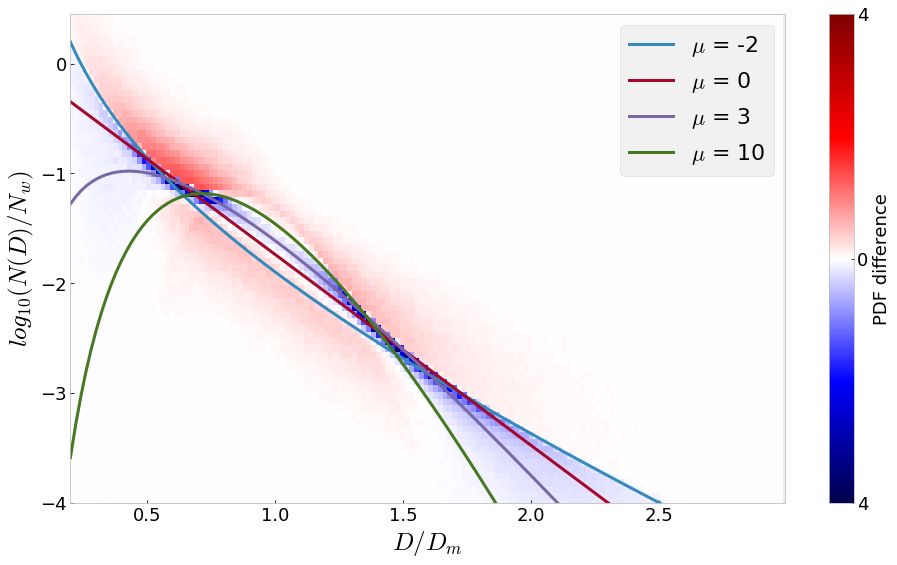

In [103]:
hd = plt.figure(figsize=[16,9])
vm = 4 #.8 #100
plt.pcolor(xx[:-1], yy[:-1], dif_hi.transpose(), cmap=plt.get_cmap('seismic') , vmin=-vm, vmax=vm)
cb2 = plt.colorbar(ticks=[-vm,0,vm])
cb2.set_label('PDF difference',fontsize=fs-4)
#cb2.set_label('PDF percent difference',fontsize=fs-4)
cb2.ax.tick_params(labelsize=fs-4)
cb2.ax.set_yticklabels([str(round(vm,1)),'0',str(round(vm,1))])
plt.ylim([-4,.45])
plt.xlim([xmin,xmax-.01])
plt.xlabel(r'$D/D_m$',fontsize=fs+3)
plt.ylabel(r'$log_{10} (N(D)/N_w)$',fontsize=fs+3)
plt.xticks(fontsize=fs-4)
plt.yticks([-4,-3,-2,-1,0],fontsize=fs-4)
for emu in [1,3,6,13]:  # subsets are defined relative to ranged given above!
    plt.plot(plex, np.log10(eff[emu]*(plex**plmu[emu])*np.exp(-(4+plmu[emu])*plex)),\
             linewidth=3,label="""$\mu$"""+' = '+str(emu-3))
plt.legend(fontsize=fs)
pvr='v5c'
hd.savefig('../../img/gamma-diff_HL-MGD_'+pvr+'.png',dpi=350,bbox_inches='tight')
plt.show()

876.6233766233768
876.6233766233768
876.6233766233768


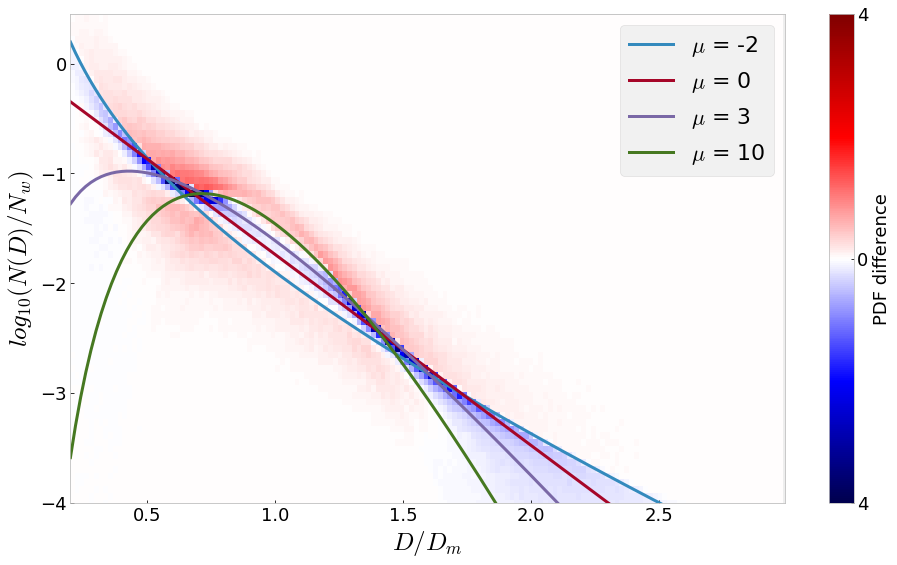

In [105]:
hd = plt.figure(figsize=[16,9])
print(np.sum(his2d_trop[0]))
print(np.sum(his2d_hl[0]))
print(np.sum(his2d_mgd[0]))
vm = 4 #100
plt.pcolor(xx[:-1], yy[:-1], dif_tr.transpose(), cmap=plt.get_cmap('seismic') , vmin=-vm, vmax=vm)
cb2 = plt.colorbar(ticks=[-vm,0,vm])
cb2.set_label('PDF difference',fontsize=fs-4)
#cb2.set_label('PDF percent difference',fontsize=fs-4)
cb2.ax.tick_params(labelsize=fs-4)
cb2.ax.set_yticklabels([str(round(vm,1)),'0',str(round(vm,1))])
plt.ylim([-4,.45])
plt.xlim([xmin,xmax-.01])
plt.xlabel(r'$D/D_m$',fontsize=fs+3)
plt.ylabel(r'$log_{10} (N(D)/N_w)$',fontsize=fs+3)
plt.xticks(fontsize=fs-4)
plt.yticks([-4,-3,-2,-1,0],fontsize=fs-4)
for emu in [1,3,6,13]:  # subsets are defined relative to ranged given above!
    plt.plot(plex, np.log10(eff[emu]*(plex**plmu[emu])*np.exp(-(4+plmu[emu])*plex)),\
             linewidth=3,label="""$\mu$"""+' = '+str(emu-3))
plt.legend(fontsize=fs)
pvr='v5c'
hd.savefig('../../img/gamma-diff_TR-MGD_'+pvr+'.png',dpi=350,bbox_inches='tight')
plt.show()

In [145]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 10), sharex=True,sharey=True)

vm = 4
c1 = axes[0].pcolor(xx[:-1], yy[:-1], dif_all.transpose(), cmap=plt.get_cmap('seismic') , vmin=-vm, vmax=vm)
cb1 = fig.colorbar(c1,ax=axes[0], ticks=[-vm,-vm/2,0,vm/2,vm], orientation='horizontal')
cb1.set_label('PDF difference',fontsize=fs-4)
cb1.ax.tick_params(labelsize=fs-4)
cb1.ax.set_yticklabels([str(round(vm,1)),'0',str(round(vm,1))])
axes[0].set_ylim([-4,.45])
axes[0].set_xlim([xmin,xmax-.01])
axes[0].set_xlabel(r'$D/D_m$',fontsize=fs+3)
axes[0].set_ylabel(r'$log_{10} (N(D)/N_w)$',fontsize=fs+3)
axes[0].tick_params(labelsize=fs-4,axis='both')
axes[0].set_yticks([-4,-3,-2,-1,0]) #,fontsize=fs-4)
#for emu in [0,15]:  # subsets are defined relative to ranged given above!
#    axes[0].plot(plex, np.log10(eff[emu]*(plex**plmu[emu])*np.exp(-(4+plmu[emu])*plex)),\
#             linewidth=3,label="""$\mu$"""+' = '+str(emu-3))
axes[0].plot(plex, np.log10(eff[0]*(plex**plmu[0])*np.exp(-(4+plmu[0])*plex)),\
    'k.',linewidth=2,label="""$\mu$"""+' = '+str(0-3))
axes[0].plot(plex, np.log10(eff[15]*(plex**plmu[15])*np.exp(-(4+plmu[15])*plex)),\
    'k-.', linewidth=2,label="""$\mu$"""+' = '+str(15-3))
axes[0].legend(fontsize=fs)

gu = np.logical_and(his2d_trop[0] > 0.000, his2d_hl[0] > 0.000) # choose points where both hists defined
toplot = np.zeros_like(his2d_trop[0])+np.nan
toplot[gu] = 100*(his2d_hl[0][gu]-his2d_trop[0][gu])/his2d_trop[0][gu] #/his2d_lp5[gu]

vm = 100
c2 = axes[1].pcolor(xx[:-1], yy[:-1], toplot.transpose(), cmap=plt.get_cmap('seismic') , vmin=-vm, vmax=vm)
cb2 = fig.colorbar(c2,ax=axes[1], ticks=[-vm,-vm/2,0,vm/2,vm], orientation='horizontal')
cb2.set_label('PDF percent difference',fontsize=fs-4)
cb2.ax.tick_params(labelsize=fs-4)
cb2.ax.set_yticklabels([str(round(vm,1)),'0',str(round(vm,1))])
axes[1].set_ylim([-4,.45])
axes[1].set_xlim([xmin,xmax-.01])
axes[1].set_xlabel(r'$D/D_m$',fontsize=fs+3)
#axes[1].set_ylabel(r'$log_{10} (N(D)/N_w)$',fontsize=fs+3)
axes[1].tick_params(labelsize=fs-4,axis='both')
#axes[1].set_yticks([-4,-3,-2,-1,0]) #,fontsize=fs-4)
#for emu in [0,15]:  # subsets are defined relative to ranged given above!
#    axes[1].plot(plex, np.log10(eff[emu]*(plex**plmu[emu])*np.exp(-(4+plmu[emu])*plex)),\
#             linewidth=3,label="""$\mu$"""+' = '+str(emu-3))
axes[1].plot(plex, np.log10(eff[0]*(plex**plmu[0])*np.exp(-(4+plmu[0])*plex)),\
    'k.',linewidth=2,label="""$\mu$"""+' = '+str(0-3))
axes[1].plot(plex, np.log10(eff[15]*(plex**plmu[15])*np.exp(-(4+plmu[15])*plex)),\
    'k-.', linewidth=2,label="""$\mu$"""+' = '+str(15-3))
axes[1].legend(fontsize=fs)
axes[0].text(1.5, 0.2, '(a)', fontsize=fs)
axes[1].text(1.5, 0.2, '(b)', fontsize=fs)

fig.tight_layout()
fig.savefig('../../img/gamma-diffs_2pan_'+pvr+'.png',dpi=350,bbox_inches='tight')
plt.show()

In [125]:
print(info(mu))

['-3.56E+0', '2.29E+1', '4.49E+0', '5.65E+0']
